In [1]:
import sys
import pandas as pd
sys.path.insert(0, './../librerias')
import utiles 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
def load_valores_cuota(start_date, AFP, fund):
    
    table_name = "AFPs_"+fund
    query_vc = "Select fecha, Admin as "+ fund + " from table_vc where Fecha>='date'"
    query_vc = query_vc.replace('table_vc',table_name).replace('Admin',AFP).replace('date',str(start_date))
	
    df_vc = utiles.get_frame_sql_user(server="localhost",
                               database="fintech",
                               username="sa",
                               password="usuariosql",
                               query=query_vc)
    df_vc.set_index('fecha', inplace = True)
    
    
    return df_vc

In [4]:
def get_fyf_recommendations(start_date):
    
    #query_fyf = "SELECT fecha_inicio, fecha_fin, A_weight, B_weight, C_weight, D_weight, E_weight from FYF where id>= (Select MIN(id)  from FyF where fecha_inicio>='start_date')-1"
    query_fyf = "SELECT fecha_inicio, fecha_fin, A_weight, B_weight, C_weight, D_weight, E_weight from FYF"
    df_fyf = utiles.get_frame_sql_user(server="localhost",
                               database="fintech",
                               username="sa",
                               password="usuariosql",
                               query=query_fyf)
    
    return df_fyf

In [5]:
def get_yields_matrix(fund_vcs):
    
    columns = list(fund_vcs)
    fund_ylds = pd.DataFrame()
    for col in columns:
        cuotas = fund_vcs[col]
        shift_cuotas = cuotas.shift(1).bfill()
        fund_ylds[col] = cuotas/shift_cuotas-1
    return fund_ylds


def load_data_frames(start_date, AFP):
    
    A = load_valores_cuota(start_date, AFP, "A")
    B = load_valores_cuota(start_date, AFP, "B")
    C = load_valores_cuota(start_date, AFP, "C")
    D = load_valores_cuota(start_date, AFP, "D")
    E = load_valores_cuota(start_date, AFP, "E")
    fund_vcs = pd.concat([A,B,C,D,E], axis = 1, sort = False)
    
    
    fyf = get_fyf_recommendations(start_date)
    #De momento veremos la rentabilidad solo a la fecha de la ultima recomendacion publica
    end_date = utiles.convert_date_to_string(fyf["fecha_fin"].max())
    start_secure_date = utiles.get_ndays_from_date(10, start_date)
    end_secure_date = utiles.get_ndays_from_date(-10, end_date)
    working_dates = utiles.get_working_dates(start_secure_date,end_secure_date)
    
    data = working_dates.merge(fyf, left_on = 'fecha', right_on = 'fecha_fin', how = 'left')
    data.set_index ('fecha', inplace = True)
    #hacemos un shift de las recomendaciones ya que me demoro 4 dias habiles en llegar al nuevo fondo
    data = data.shift(3)
    data = data.bfill()
    
    # ahora recien puedo cortar por la fecha del start_date ya que ya no hay riesgos
    # de que queden fechas sin carteras mappeadas
    data = data[data.index>=utiles.convert_string_to_datetime(start_date)]
    data = data[data.index<=utiles.convert_string_to_datetime(end_date)]
    
    data = data.merge(fund_vcs, how = 'left', left_index = True, right_index = True )
    
    #acá hay que cersiorarse de que no hayan NAS EN LAS CUOTASSS
    
    
    weights = data[["A_weight", "B_weight", "C_weight", "D_weight", "E_weight"]]
    weights.rename(columns={'A_weight':'A','B_weight':'B', 'C_weight':'C', 'D_weight':'D', 'E_weight':'E'}, inplace = True)
                                 
    fund_vcs = data[["A","B","C","D","E"]] #ahora queda con las mismas fechas que weights
    yields = get_yields_matrix(fund_vcs)
    fyf_yield = np.diag(weights.dot(yields.T))
    yields["FyF"] = fyf_yield
    
    #Ahora tenemos los retornos diarios de todos los fondos y FyF
    indices = 100*(yields + 1).cumprod()
    
    return indices, data

def write_outputs(indices, data):
    wb = utiles.open_workbook("outputs.xlsx", True, True)
    utiles.clear_sheet_xl(wb, "indices")
    utiles.clear_sheet_xl(wb, "full_data")
    utiles.paste_val_xl(wb, "indices", (1, 1), indices)
    utiles.paste_val_xl(wb, "full_data", (1, 1), data)

In [8]:
admin_name = "CAPITAL"

In [9]:
date_from = "2011-07-27"


In [10]:
indices, data = load_data_frames(date_from, admin_name)

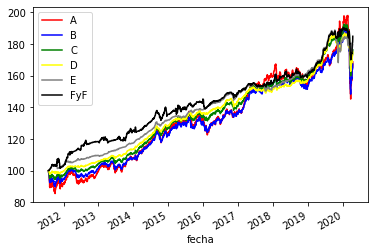

In [14]:
indices.reset_index(inplace=True)
ax = plt.gca()
indices.plot(kind='line',x='fecha',y='A',color='red', ax=ax)
indices.plot(kind='line',x='fecha',y='B',color='blue', ax=ax)
indices.plot(kind='line',x='fecha',y='C',color='green', ax=ax)
indices.plot(kind='line',x='fecha',y='D',color='yellow', ax=ax)
indices.plot(kind='line',x='fecha',y='E',color='grey', ax=ax)
indices.plot(kind='line',x='fecha',y='FyF',color='black', ax=ax)
plt.show()